In [16]:
import time
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import torch
from torch.functional import F
from torch_geometric.nn import GCNConv, to_hetero, GATConv
from torch_geometric.data import Data
from torch_geometric import transforms as T
from torch_geometric.utils import is_undirected
from torch_geometric.utils.convert import to_networkx
import networkx as nx

from prettytable import PrettyTable

#### Load train dataset

In [17]:
train_dataset = torch.load(r'c:\Users\gavin\Desktop\power_system_project-main\ref_code\yadong-zhang power_system_project main ref_code-train_test_dataset\node_prediction_train_dataset.pt')
# C:train_test_dataset/node_prediction_train_dataset.pt
data = train_dataset.dataset[0]
data

HeteroData(
  node={
    x=[118, 8],
    y=[118],
  },
  (node, branch, node)={
    edge_index=[2, 173],
    edge_attr=[173, 3],
  },
  (node, trafo, node)={
    edge_index=[2, 13],
    edge_attr=[13, 5],
  }
)

#### Create GNN model

In [18]:
## Custom loss function
class customLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_max_gen, y_min_gen, y_true):
        loss1 = F.mse_loss(y_pred, y_true)  # Equality constraint
        loss2 = torch.sum(torch.min(y_pred - y_min_gen, torch.zeros((y_pred.shape[0])))) # Inequality constraint, lower constraint
        loss3 = torch.sum(torch.max(y_pred - y_max_gen, torch.zeros((y_pred.shape[0])))) # Inequality constraint, upper constraint

        loss = loss1 - 1.5*loss2 + 1.5*loss3    # Overall loss

        return loss

In [19]:
## Clamp layer
import torch
class ClampLayer(torch.nn.Module):
    def __init__(self, min_value=-594, max_value=594):
        super(ClampLayer, self).__init__()
        self.min_value = min_value
        self.max_value = max_value

    def forward(self, x):
        return torch.clamp(x, self.min_value, self.max_value)

In [20]:
class GNN_model(torch.nn.Module):
    def __init__(self):
        super(GNN_model, self).__init__()
        self.conv1 = GCNConv(8, 4)
        self.conv2 = GCNConv(4, 2)
        self.conv3 = GCNConv(2, 1)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.lin = torch.nn.Linear(in_features=118, out_features=118)
        # self.clamp = ClampLayer(-594, 594)
        
    def forward(self, x, edge_index):
        x = F.leaky_relu(self.conv1(x, edge_index))
        x = F.leaky_relu(self.conv2(x, edge_index))
        x = F.leaky_relu(self.conv3(x, edge_index))
        x = self.flatten(x)
        x = self.lin(x)
        # Physical constraints
        # x = self.clamp(x)

        return x

#### Model training

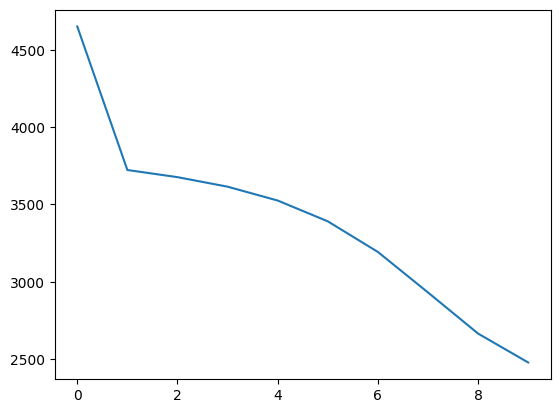

In [21]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instance the model
# model = GCN_model(batch_size=batch_size, 
#                   num_nodes=num_nodes,
#                   in_features=num_node_features, 
#                   out_features=num_y_features)
model = GNN_model()
# model = to_hetero_with_bases(model, data.metadata(), num_bases=1)
model = to_hetero(model, data.metadata(), aggr='mean')
model.to(device)

# Custom loss
# custom_loss = customLoss()

# Set optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set number of epochs
epochs = 10

# Max_alowed_pf
max_allowed_pf = torch.tensor([594.])

# Set model to training mode
model.train()

## Train and test the model
epoch_loss = []
start_time = time.time()
for epoch in range(epochs):
    batch_loss = []
    for batch_data in train_dataset.dataset:
        batch_data.to(device)
        # batch_data = T.ToUndirected()(batch_data)
        # batch_data = T.AddSelfLoops()(batch_data)
        optimizer.zero_grad()
        # out, y_gen, y_max_gen, y_min_gen = model(batch_data.x_dict, batch_data.edge_index_dict)
        y_pred = model(batch_data.x_dict, batch_data.edge_index_dict)
        # y_gen_max = batch_data.x_dict['node'][[0, 1, 2, 5, 7], 2]
        # y_gen_min = batch_data.x_dict['node'][[0, 1, 2, 5, 7], 3]

        loss = F.mse_loss(y_pred['node'], batch_data['node'].y)
        # loss = custom_loss(y_pred['node'], y_gen_max, y_gen_min, batch_data['node'].y)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(np.mean(batch_loss))

end_time = time.time()
training_time = (end_time - start_time)/60

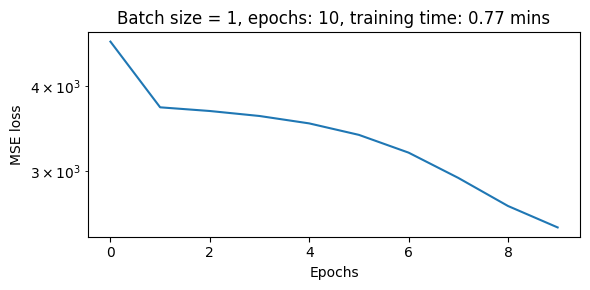

In [22]:
plt.figure(figsize=(6, 3))
# Don't forget to change training time
plt.title(f'Batch size = {1}, epochs: {epochs}, training time: {training_time:.2f} mins')
plt.plot(epoch_loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.tight_layout()
# plt.savefig(f'node_prediction_loss.jpg')

In [ ]:
torch.save(model, r'C:\Users\gavin\Desktop\power_system_project-main\ref_code\yadong-zhang power_system_project main ref_code-train_test_dataset/node_prediction_model_trained.pt''node_prediction_model_trained.pt')
# node_prediction_model_trained.pt